# Scene
## Recommended List
- 8: amusement_park
- 10: aqueduct
- 12: arch (!)
- 84: castle (!)
- 91: church/outdoor
- 94: cliff (!)
- 117: desert/vegetation (!)
- 204: lagoon (!!)
- 209: lawn
- 229: water (!)
- 230: outdoor
- 232: mountain
- 234: mountain snowy
- 362: yard (!)
- 364: zen_garden (!!)

In [1]:
import os, sys
os.environ['GLOG_minloglevel'] = '2'    # suprress Caffe verbose prints
import caffe
import settings
import numpy as np
from numpy.linalg import norm
import scipy.misc, scipy.io
import argparse 
import util
from sampler import Sampler
from sampling_class import ClassConditionalSampler
from sampling_class import get_code
import settings
from conditional_sampling_from_real_image import conditional_sampling_from_real_image

In [2]:
# Index of neurons in fc layers or channels in conv layers
# from 0 to 364
units="204"       

label_to_name = {"8":"amusement_park.jpg",
                 "10":"aqueduct.jpg",
                 "12":"arch.jpg",
                 "84":"castle.jpg",
                 "91":"church.jpg",
                 "94":"cliff.jpg",
                 "117":"desert_vegetation.jpg",
                 "204":"lagoon.jpg",
                 "209":"lawn.jpg",
                 "229":"water.jpg",
                 "230":"outdoor.jpg",
                 "232":"mountain.jpg",
                 "234":"mountain_snowy.jpg",
                 "362":"yard.jpg",
                 "364":"zen_garden.jpg"}

if units in label_to_name:
    img_name = label_to_name[units]
else:
    img_name = "defalut.jpg"

In [3]:
opt_layer="fc6"
act_layer="fc8"
xy=0              # Spatial position for conv layers, for fc layers: xy = 0

n_iters=100       # Run for N iterations
reset_every=0     # Reset the code every N iterations (for diversity)
save_every=5      # Save a sample every N iterations
lr=0.5 
lr_end=0.5        # Linearly decay toward this ending lr (e.g. for decaying toward 0, set lr_end = 1e-10)
threshold=0.      # Filter out samples below this threshold e.g. 0.98
seed=0

# -----------------------------------------------
# Multipliers in the update rule Eq.11 in the paper
# -----------------------------------------------
epsilon1=1e-5     # prior
epsilon2=1.       # condition
epsilon3=1e-17    # noise
epsilon4=0.
# -----------------------------------------------

# Start from a random code. To start from a real code, replace with a path e.g. "images/filename.jpg"
init_file="images/" + img_name

# Condition net
# net_weights="nets/caffenet/bvlc_reference_caffenet.caffemodel"
# net_definition="nets/caffenet/caffenet.prototxt"
net_weights="nets/placesCNN/alexnet_places365.caffemodel"
net_definition="nets/placesCNN/deploy_alexnet_places365.prototxt"

output_dir=("output/" + act_layer + "_chain_" + units + "_eps1_" + 
            str(epsilon1) + "_eps3_" + str(epsilon3))

In [4]:
# Default to constant learning rate
if lr_end < 0:
    lr_end = lr

# summary
print "-------------"
print " units: %s    xy: %s" % (units, xy)
print " n_iters: %s" % n_iters
print " reset_every: %s" % reset_every
print " save_every: %s" % save_every
print " threshold: %s" % threshold

print " epsilon1: %s" % epsilon1
print " epsilon2: %s" % epsilon2
print " epsilon3: %s" % epsilon3
print " epsilon4: %s" % epsilon4

print " start learning rate: %s" % lr
print " end learning rate: %s" % lr_end
print " seed: %s" % seed
print " opt_layer: %s" % opt_layer
print " act_layer: %s" % act_layer
print " init_file: %s" % init_file
print "-------------"
print " output dir: %s" % output_dir
print " net weights: %s" % net_weights
print " net definition: %s" % net_definition

-------------
 units: 204    xy: 0
 n_iters: 100
 reset_every: 0
 save_every: 5
 threshold: 0.0
 epsilon1: 1e-05
 epsilon2: 1.0
 epsilon3: 1e-17
 epsilon4: 0.0
 start learning rate: 0.5
 end learning rate: 0.5
 seed: 0
 opt_layer: fc6
 act_layer: fc8
 init_file: images/lagoon.jpg
-------------
 output dir: output/fc8_chain_204_eps1_1e-05_eps3_1e-17
 net weights: nets/placesCNN/alexnet_places365.caffemodel
 net definition: nets/placesCNN/deploy_alexnet_places365.prototxt


Loaded init code:  (1, 4096)
step: 0000	 max:  341 [0.22]	 obj:  204 [0.14]	 norm: [0.91]
step: 0001	 max:  204 [0.61]	 obj:  204 [0.61]	 norm: [0.37]
step: 0002	 max:  204 [0.85]	 obj:  204 [0.85]	 norm: [0.15]
step: 0003	 max:  204 [0.85]	 obj:  204 [0.85]	 norm: [0.11]
step: 0004	 max:  204 [0.96]	 obj:  204 [0.96]	 norm: [0.02]
step: 0005	 max:  204 [0.87]	 obj:  204 [0.87]	 norm: [0.14]
step: 0006	 max:  204 [0.91]	 obj:  204 [0.91]	 norm: [0.08]
step: 0007	 max:  204 [0.96]	 obj:  204 [0.96]	 norm: [0.03]
step: 0008	 max:  204 [0.95]	 obj:  204 [0.95]	 norm: [0.03]
step: 0009	 max:  204 [0.99]	 obj:  204 [0.99]	 norm: [0.00]
step: 0010	 max:  204 [0.97]	 obj:  204 [0.97]	 norm: [0.01]
step: 0011	 max:  204 [0.98]	 obj:  204 [0.98]	 norm: [0.01]
step: 0012	 max:  204 [0.98]	 obj:  204 [0.98]	 norm: [0.01]
step: 0013	 max:  204 [0.99]	 obj:  204 [0.99]	 norm: [0.01]
step: 0014	 max:  204 [0.99]	 obj:  204 [0.99]	 norm: [0.01]
step: 0015	 max:  204 [0.98]	 obj:  204 [0.98]	 norm: [0

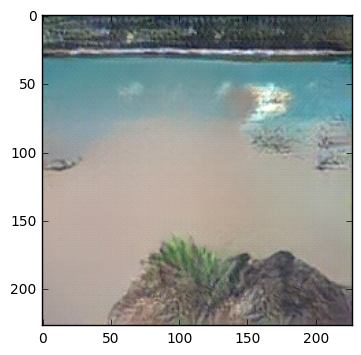

In [5]:
encoder_definition = settings.encoder_definition
encoder_weights = settings.encoder_weights
generator_definition = settings.generator_definition
generator_weights = settings.generator_weights

output_image, _ = conditional_sampling_from_real_image(encoder_definition, encoder_weights,
					 generator_definition, generator_weights,
                     net_definition, net_weights,
                     units, xy,
                     n_iters,
                     reset_every,
                     save_every,
                     threshold,
                     epsilon1, epsilon2, epsilon3, epsilon4,
                     lr, lr_end,
                     seed,
                     opt_layer,
                     act_layer,
                     init_file,
                     output_dir)

import matplotlib.pyplot as plt
%matplotlib inline

img = output_image[:,::-1, :, :] # Convert from BGR to RGB
img = util.deprocess(img, in_range=(-120,120))
plt.imshow(img)